In [147]:
import os
import sys
import gzip
import random
import platform
import warnings
import collections
from tqdm import tqdm, tqdm_notebook
import re
import requests
import numpy as np
import time
import copy
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.datasets import load_iris
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [148]:
train_dir = '/opt/ml/input/data/train'
test_dir = '/opt/ml/input/data/eval'
train_image = train_dir + '/images'
train_df = pd.read_csv(train_dir + '/train.csv')
test_df = pd.read_csv(test_dir + '/info.csv')
path_df = train_dir + '/train.csv'

In [149]:
def age_to_classification(age):
    age = int(age)
    if age < 30 :
        trans_age = 0
    elif 30 <= age < 60:
        trans_age = 1
    elif age >= 60:
        trans_age = 2
    return trans_age

class CustomDataset(Dataset):
    def __init__(self, transform, path, image_path):
        self.path = path
        self.transform = transform
        self.image_path = image_path
        self.df = self.make_dataset()
        self.df['score'] = self.df['value'] * 6 + self.df['gender'] * 3 + self.df['age'] 
        self.y = self.df['score'].values
        self.column = self.df.columns

        
    def __len__(self):
        return len(self.df)    
    

    def __getitem__(self, idx):
        image_path = '/'.join([train_image, self.df['path'][idx], self.df['file'][idx]])
        image = Image.open(image_path)
        #image = np.array(image)
        X, y = image, self.y[idx]
        if self.transform:
            X = self.transform(X)
        return X, y
        

    def make_dataset(self):
        cnt = [0, 0, 0] 
        MASK = 0
        INCORRECT_MASK = 1
        NORMAL = 2
        path_list = []
        name_list = []
        result = []
        train_df = pd.read_csv(self.path)
        for idx, i in enumerate(train_df['path'].values):
            for name in os.listdir(self.image_path + '/' + i):
                if name.find('incorrect') == 0:
                    path_list.append(i)
                    cnt[INCORRECT_MASK] += 1
                    name_list.append(name)
                    result.append(INCORRECT_MASK)
                elif name.find('mask') == 0:
                    path_list.append(i)
                    cnt[MASK] += 1
                    name_list.append(name)
                    result.append(MASK)
                elif name.find('normal') == 0:
                    path_list.append(i)
                    cnt[NORMAL] += 1
                    name_list.append(name)
                    result.append(NORMAL)
                else:
                    continue
        train_image_df = pd.DataFrame({'path': path_list, 'file' : name_list, 'value' : result})
        train_result_df = pd.merge(train_df, train_image_df, how ='outer', on = 'path')
        train_result_df['gender'] = train_result_df['gender'].map({'female' : 1, 'male' : 0})
        train_result_df['age'] = train_result_df['age'].map(age_to_classification)
        return train_result_df

In [150]:
dataset_train = CustomDataset(transform = transforms.Compose([
                                    transforms.Resize((256, 192)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ]), path = path_df, image_path = train_image)

In [151]:
len(dataset_train)
#                                    transforms.Resize((224, 224)),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

18900

In [152]:
print(dataset_train.column)

Index(['id', 'gender', 'race', 'age', 'path', 'file', 'value', 'score'], dtype='object')


In [153]:
image, labels = next(iter(dataset_train))
image, labels

(tensor([[[ 1.5639,  1.5639,  1.5639,  ...,  1.5297,  1.4098,  1.2557],
          [ 1.5639,  1.5639,  1.5639,  ...,  1.5297,  1.3927,  1.2385],
          [ 1.5639,  1.5639,  1.5639,  ...,  1.5125,  1.3755,  1.2043],
          ...,
          [ 0.8618,  0.8447,  0.8104,  ...,  1.2899,  1.2728,  1.2214],
          [ 0.8447,  0.8276,  0.7933,  ...,  1.1529,  1.1015,  1.0673],
          [ 0.8447,  0.8276,  0.7762,  ...,  0.8618,  0.7419,  0.6392]],
 
         [[ 1.7108,  1.7108,  1.7108,  ...,  1.7108,  1.5882,  1.4307],
          [ 1.7108,  1.7108,  1.7108,  ...,  1.7108,  1.5707,  1.4132],
          [ 1.7108,  1.7108,  1.7108,  ...,  1.6933,  1.5532,  1.3782],
          ...,
          [ 0.1877,  0.1527,  0.1176,  ...,  0.5378,  0.5203,  0.4678],
          [ 0.1702,  0.1352,  0.1001,  ...,  0.3803,  0.3452,  0.2927],
          [ 0.1702,  0.1352,  0.0826,  ...,  0.0826, -0.0399, -0.1450]],
 
         [[ 1.8557,  1.8557,  1.8557,  ...,  1.8383,  1.7163,  1.5594],
          [ 1.8557,  1.8557,

In [154]:
datasets = {}

In [155]:
train_idx, vaild_idx = train_test_split(list(range(len(dataset_train))), test_size=0.2)

In [156]:
datasets['train'] = Subset(dataset_train, train_idx)
datasets['vaild'] = Subset(dataset_train, vaild_idx)

In [157]:
dataloaders, batch_num = {}, {}
dataloaders['train'] = DataLoader(dataset=datasets['train'],
                                    batch_size=64,
                                    shuffle=True,
                                    num_workers=8,
                                    )

dataloaders['valid'] = DataLoader(dataset=datasets['vaild'],
                                    batch_size=64,
                                    shuffle=True,
                                    num_workers=8,
                                    )

In [158]:
images, labels = next(iter(dataloaders['train']))
batch_num['train'], batch_num['valid'] = len(dataloaders['train']), len(dataloaders['valid'])

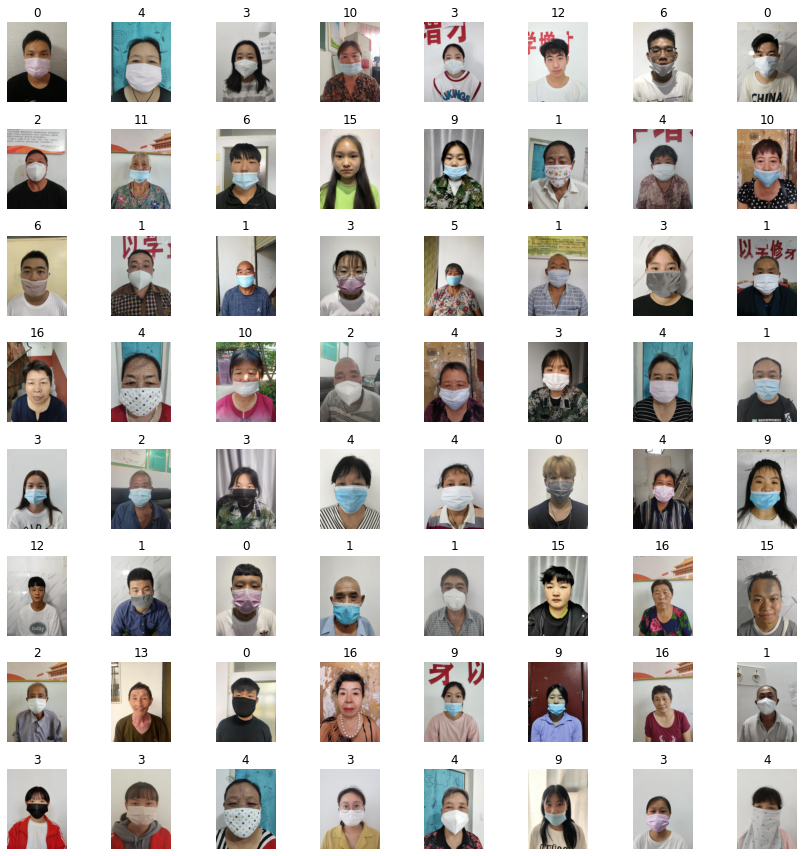

In [159]:
plt.figure(figsize=(12,12))

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)


for n, (image, label) in enumerate(zip(images, labels), start=1):
    plt.subplot(8,8,n)
    imshow(image)
    plt.title("{}".format(label))
    plt.axis('off')
plt.tight_layout()
plt.show()    

In [160]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b1', num_classes= 18)
# ... image preprocessing as in the classification example ...
image = image.unsqueeze(dim = 0)
print(image.shape) # torch.Size([1, 3, 224, 224])

features = model.extract_features(image)
print(features.shape)

Loaded pretrained weights for efficientnet-b1
torch.Size([1, 3, 256, 192])
torch.Size([1, 1280, 8, 6])


In [167]:
tqdm.pandas()
from sklearn.metrics import f1_score

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    prevous_F1 = 0
    since = time.time()
    iter_valid_f1 = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_F1 = 0.0
    F1_lower_stack = 0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    epoch_F1_point = 0 
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            print(epoch_loss, epoch_acc)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
            # deep copy the model
            iter_f1_score = f1_score(y_true=labels.cpu().numpy(), y_pred=preds.cpu().numpy(), average="macro")
            if phase == 'valid':
                print(labels,  preds)
                iter_valid_f1.append(iter_f1_score)
                epoch_valid_f1_score = np.mean(iter_valid_f1)

                print('f1 score = ' + str(epoch_valid_f1_score))
                if prevous_F1 < epoch_valid_f1_score:
                    F1_lower_stack = 0
                    prevous_F1 = epoch_valid_f1_score

                    if best_F1 < epoch_valid_f1_score:
                        best_F1 = epoch_valid_f1_score
                        torch.save(model.state_dict(), '/opt/ml/input/data/train' + 'model.pt')

                else:
                    F1_lower_stack += 1
                    print('plus F1_lower_stack, stack = ', str(F1_lower_stack))
                    if F1_lower_stack >= 3:
                        time_elapsed = time.time() - since
                        # load best model weights
                        epoch_F1_point = 1
                        break
        if epoch_F1_point == 1:
            break

    time_elapsed = time.time() - since
    # load best model weights
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    #print('Best valid Acc: %d - %.1f' %(epoch_valid_f1_score))
    print('model saved')
    return model

/opt/conda/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [162]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), 
                         lr = 0.05,
                         momentum=0.9,
                         weight_decay=1e-4)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

In [163]:
torch.cuda.empty_cache()

In [164]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 10)

  0%|          | 0/237 [00:00<?, ?it/s]

Epoch 0/9
----------


  0%|          | 0/60 [00:00<?, ?it/s]

0.5281690513843267 83.49867724867725
train Loss: 0.53 Acc: 83.5


  0%|          | 0/237 [00:00<?, ?it/s]

0.37624709106736604 88.41269841269842
valid Loss: 0.38 Acc: 88.4
tensor([ 6, 10,  0, 12], device='cuda:0') tensor([ 6, 10,  0, 12], device='cuda:0')
f1 score = 1.0
Epoch 1/9
----------


  0%|          | 0/60 [00:00<?, ?it/s]

0.15972984503343624 94.50396825396827
train Loss: 0.16 Acc: 94.5


  0%|          | 0/237 [00:00<?, ?it/s]

0.19999612788990062 93.4920634920635
valid Loss: 0.20 Acc: 93.5
tensor([ 0, 10, 16,  3], device='cuda:0') tensor([ 0, 10, 16,  3], device='cuda:0')
f1 score = 1.0
plus F1_lower_stack, stack =  1
Epoch 2/9
----------


  0%|          | 0/60 [00:00<?, ?it/s]

0.07486548752932952 97.48015873015873
train Loss: 0.07 Acc: 97.5


  0%|          | 0/237 [00:00<?, ?it/s]

0.13682822422668026 95.6878306878307
valid Loss: 0.14 Acc: 95.7
tensor([3, 0, 0, 4], device='cuda:0') tensor([3, 0, 0, 4], device='cuda:0')
f1 score = 1.0
plus F1_lower_stack, stack =  2
Epoch 3/9
----------


  0%|          | 0/60 [00:00<?, ?it/s]

0.06528786280483165 97.8373015873016
train Loss: 0.07 Acc: 97.8


100%|██████████| 60/60 [00:05<00:00, 11.70it/s]

0.23058113092310215 92.0899470899471
valid Loss: 0.23 Acc: 92.1
tensor([7, 3, 1, 0], device='cuda:0') tensor([7, 3, 1, 0], device='cuda:0')
f1 score = 1.0
plus F1_lower_stack, stack =  3
Training complete in 3m 49s
model saved


In [165]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [166]:
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
dataset_test = TestDataset(img_paths = image_paths, transform = transforms.Compose([
                                    transforms.Resize((256, 192)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ]))

loader = DataLoader(
    dataset_test,
    batch_size=64,
    shuffle=True,
    num_workers=4,
)
print(len(loader))
# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model.load_state_dict(torch.load('/opt/ml/input/data/train' + 'model.pt'))
#optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

197
test inference is done!
